## <center>Projet VitaliTaxi</center>
## <center>Les courses de taxi New-Yorkais</center>

## Partie 1 : Exploration et Préparation des données

### 1. Importation des données des courses de taxi jaunes

* Pour commencer on va importer les bibliothèque nécessaires 

In [1]:
#!pip install pyarrow
#!pip install xgboost
#!pip install geopandas

In [2]:
import pandas as pd # bibliothèque de manipulation de données tabulaires
import numpy as np #  bibliothèque de manipulation des tableaux de données multidimensionnels
import matplotlib.pyplot as plt # bibliothèque de visualisation de données
import seaborn as sns #  bibliothèque de visualisation de données : graphiques statistiques
import pyarrow.parquet as pq
import geopandas as gpd

* On importe les données yellow_tripdata_2023-03

In [3]:
trips = pq.read_table('yellow_tripdata_2023-03.parquet')
trips = trips.to_pandas()

print("Nombre de lignes : " , trips.shape[0])
print("Nombre de variables : ",trips.shape[1] )

Nombre de lignes :  3403766
Nombre de variables :  19


In [4]:
trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,N,238,42,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


* Opération sur le temps et la durée de la course ⌚

In [5]:
trips.insert(0, 'year', trips['tpep_pickup_datetime'].dt.year)
trips.insert(1, 'day', trips['tpep_pickup_datetime'].dt.day)
trips.insert(2, 'hour', trips['tpep_pickup_datetime'].dt.hour)
trips.insert(3, 'trip_duration', (trips['tpep_dropoff_datetime'] - trips['tpep_pickup_datetime']).dt.total_seconds() / 3600)
trips.head()

,year,day,hour,trip_duration,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2023,1,0,0.166667,2,2023-03-01 00:06:43,2023-03-01 00:16:43,1.0,0.00,1.0,...,2,8.6,1.0,0.5,0.00,0.0,1.0,11.10,0.0,0.00
1,2023,1,0,0.518056,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,...,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,2023,1,0,0.239444,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,...,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,2023,1,0,0.191111,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,...,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2023,1,0,0.050556,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,...,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00


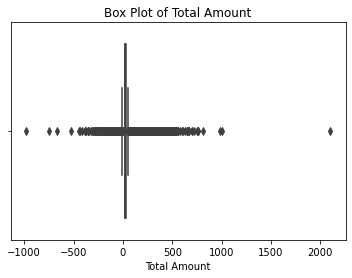

In [6]:
import seaborn as sns

sns.boxplot(x=trips['total_amount'])
plt.xlabel('Total Amount')
plt.title('Box Plot of Total Amount')
plt.show()

On remarque des valeurs aberrantes sur le coût des courses, la durée des courses et leurs distances.  
On les supprime.

In [7]:
trips = trips[trips['total_amount'] <= 2000]
trips = trips[trips['total_amount'] > 0]
trips = trips[trips['trip_duration'] <= 24]
trips = trips[trips['trip_duration'] > 0]
trips = trips[trips['trip_distance'] >= 0.1]

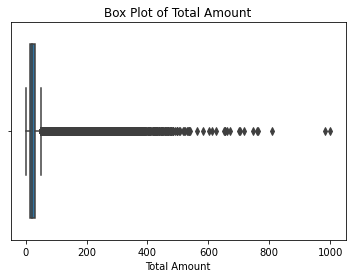

In [8]:
import seaborn as sns

sns.boxplot(x=trips['total_amount'])
plt.xlabel('Total Amount')
plt.title('Box Plot of Total Amount')
plt.show()

In [9]:
trips['total_amount'].max()

1000.0

* Description des données

In [10]:
print(trips.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321024 entries, 1 to 3403765
Data columns (total 23 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   year                   int64         
 1   day                    int64         
 2   hour                   int64         
 3   trip_duration          float64       
 4   VendorID               int32         
 5   tpep_pickup_datetime   datetime64[ns]
 6   tpep_dropoff_datetime  datetime64[ns]
 7   passenger_count        float64       
 8   trip_distance          float64       
 9   RatecodeID             float64       
 10  store_and_fwd_flag     object        
 11  PULocationID           int32         
 12  DOLocationID           int32         
 13  payment_type           int64         
 14  fare_amount            float64       
 15  extra                  float64       
 16  mta_tax                float64       
 17  tip_amount             float64       
 18  tolls_amount          

### 2. Exploration et visualisation des données

In [11]:
trips.describe()

,year,day,hour,trip_duration,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.240511e+06,3.321024e+06,3.240511e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.321024e+06,3.240511e+06,3.240511e+06
mean,2.023000e+03,1.588707e+01,1.435963e+01,2.835193e-01,1.724455e+00,1.352784e+00,3.969484e+00,1.543216e+00,1.655845e+02,1.641833e+02,1.162977e+00,1.913500e+01,1.666934e+00,4.975627e-01,3.542637e+00,5.746261e-01,9.992447e-01,2.819338e+01,2.330219e+00,1.060446e-01
std,3.498595e-02,8.986244e+00,5.748051e+00,7.189820e-01,4.572337e-01,8.885091e-01,1.939261e+02,6.896526e+00,6.362686e+01,6.963867e+01,4.731068e-01,1.738085e+01,1.830028e+00,3.528190e-02,3.941618e+00,2.104183e+00,2.345652e-02,2.193740e+01,6.289886e-01,3.482964e-01
min,2.001000e+03,1.000000e+00,0.000000e+00,2.777778e-04,1.000000e+00,0.000000e+00,1.000000e-01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-1.719000e+01,0.000000e+00,-5.000000e-01,-4.420000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.023000e+03,8.000000e+00,1.100000e+01,1.258333e-01,1.000000e+00,1.000000e+00,1.100000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,9.300000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.596000e+01,2.500000e+00,0.000000e+00
50%,2.023000e+03,1.600000e+01,1.500000e+01,2.044444e-01,2.000000e+00,1.000000e+00,1.800000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.350000e+01,1.000000e+00,5.000000e-01,2.860000e+00,0.000000e+00,1.000000e+00,2.065000e+01,2.500000e+00,0.000000e+00
75%,2.023000e+03,2.400000e+01,1.900000e+01,3.288889e-01,2.000000e+00,1.000000e+00,3.420000e+00,1.000000e+00,2.330000e+02,2.340000e+02,1.000000e+00,2.120000e+01,2.500000e+00,5.000000e-01,4.380000e+00,0.000000e+00,1.000000e+00,2.976000e+01,2.500000e+00,0.000000e+00
max,2.023000e+03,3.100000e+01,2.300000e+01,2.399528e+01,6.000000e+00,8.000000e+00,2.169870e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,9.599000e+02,1.375000e+01,4.000000e+00,9.843000e+02,1.770000e+02,1.000000e+00,1.000000e+03,2.500000e+00,1.250000e+00


#### 2.1 Valeurs Manquantes

* Visualisation des données manquantes

<AxesSubplot:>

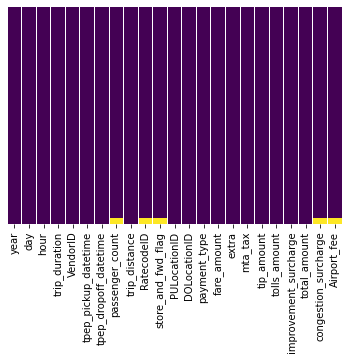

In [12]:
sns.heatmap(trips.isnull(), yticklabels=False, cbar=False, cmap='viridis')

* Comptage les valeurs manquantes par variable

In [13]:
missing_values = trips.isnull().sum()
print(missing_values)

year                         0
day                          0
hour                         0
trip_duration                0
VendorID                     0
tpep_pickup_datetime         0
tpep_dropoff_datetime        0
passenger_count          80513
trip_distance                0
RatecodeID               80513
store_and_fwd_flag       80513
PULocationID                 0
DOLocationID                 0
payment_type                 0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
improvement_surcharge        0
total_amount                 0
congestion_surcharge     80513
Airport_fee              80513
dtype: int64


#### 2.2 Visualisation des Variables

In [14]:
trips.head()

,year,day,hour,trip_duration,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,...,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
1,2023,1,0,0.518056,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,...,1,52.7,6.0,0.5,12.54,0.0,1.0,76.49,2.5,1.25
2,2023,1,0,0.239444,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,...,1,18.4,3.5,0.5,4.65,0.0,1.0,28.05,2.5,0.00
3,2023,1,0,0.191111,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,...,1,15.6,3.5,0.5,4.10,0.0,1.0,24.70,2.5,0.00
4,2023,1,0,0.050556,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,...,1,7.2,1.0,0.5,2.44,0.0,1.0,14.64,2.5,0.00
5,2023,1,0,0.140278,1,2023-03-01 00:09:09,2023-03-01 00:17:34,1.0,1.20,1.0,...,1,10.0,3.5,0.5,3.00,0.0,1.0,18.00,2.5,0.00


- Comptage du nombre de passagers

C:\tools\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


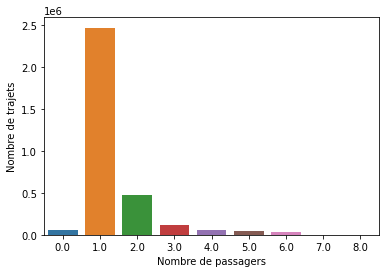

In [15]:
sns.countplot(trips["passenger_count"])
plt.xlabel("Nombre de passagers")
plt.ylabel("Nombre de trajets")
plt.show()

- Visualisation de la relation entre le type de paiement et le nombre de course

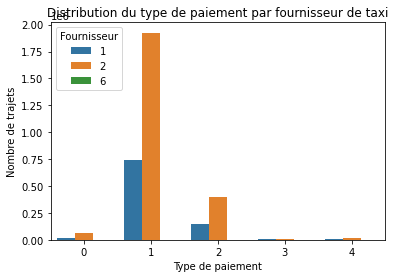

In [16]:
sns.countplot(x='payment_type', hue='VendorID', data=trips)
plt.xlabel("Type de paiement")
plt.ylabel("Nombre de trajets")
plt.title("Distribution du type de paiement par fournisseur de taxi")
plt.legend(title="Fournisseur")
plt.show()

- Observation de la distance des trajets

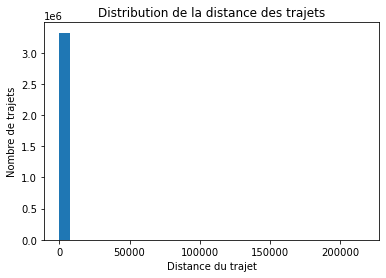

In [17]:
plt.hist(trips['trip_distance'], bins=30)
plt.xlabel('Distance du trajet')
plt.ylabel('Nombre de trajets')
plt.title('Distribution de la distance des trajets')
plt.show()

- Aperçu du nombre de trajets par fournisseur

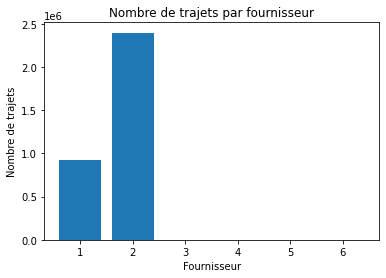

In [18]:
vendor_counts = trips['VendorID'].value_counts()
plt.bar(vendor_counts.index, vendor_counts.values)
plt.xlabel('Fournisseur')
plt.ylabel('Nombre de trajets')
plt.title('Nombre de trajets par fournisseur')
plt.show()

- Visualisation de l'heure de prise en charge

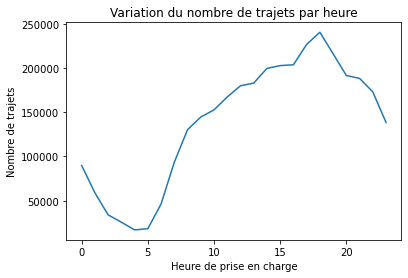

In [19]:
# Exemple avec l'heure de prise en charge
pickup_counts = trips['tpep_pickup_datetime'].dt.hour.value_counts().sort_index()
plt.plot(pickup_counts.index, pickup_counts.values)
plt.xlabel('Heure de prise en charge')
plt.ylabel('Nombre de trajets')
plt.title('Variation du nombre de trajets par heure')
plt.show()

- Observation du montant des pourboires

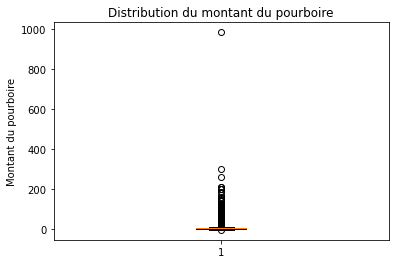

In [20]:
# Exemple avec la variable "tip_amount"
plt.boxplot(trips['tip_amount'])
plt.ylabel('Montant du pourboire')
plt.title('Distribution du montant du pourboire')
plt.show()

* On reperd la valeur aberrante et on la supprime

In [21]:
trips['tip_amount'].idxmax()

361044

In [22]:
trips = trips.drop(361044)

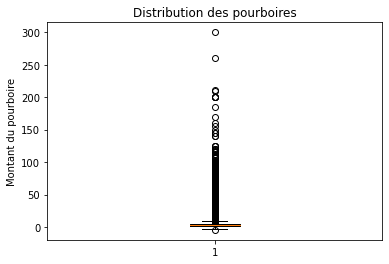

In [23]:
# Créer la figure et l'axe
fig, ax = plt.subplots()

# Tracer la boîte à moustaches
ax.boxplot(trips['tip_amount'])

# Ajouter un titre et des étiquettes d'axe
ax.set_title("Distribution des pourboires")
ax.set_ylabel("Montant du pourboire")

# Afficher la figure
plt.show()

* Zoom sur la partie boite

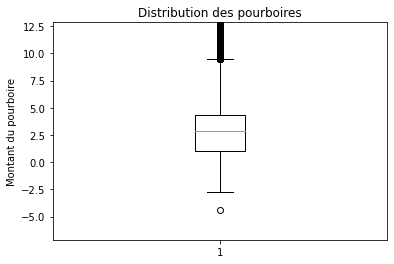

In [24]:
fig, ax = plt.subplots()

ax.boxplot(trips['tip_amount'])
ax.set_title("Distribution des pourboires")
ax.set_ylabel("Montant du pourboire")

median = trips['tip_amount'].median()
ax.set_ylim(bottom=median - 10, top=median + 10)

plt.show()

* Nombre de course suivant l'heure

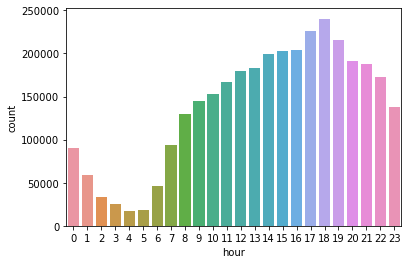

In [25]:
sns.countplot(x='hour', data=trips)
plt.show()

* Prix moyen des courses en fonction du jour de la semaine et de l'heure de la journée

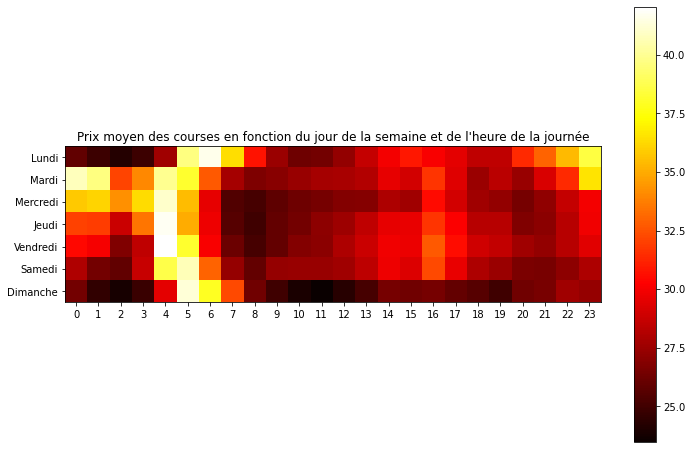

In [26]:
trips['day_of_week'] = trips['tpep_pickup_datetime'].dt.dayofweek

# Calculer le prix moyen des courses en regroupant par jour de la semaine et heure de la journée
average_price = trips.groupby(['day_of_week', 'hour'])['total_amount'].mean()

# Créer une table pivotante à partir des données
pivot_table = average_price.unstack()

# Déplacer les étiquettes des jours de la semaine pour commencer par lundi
pivot_table = pivot_table.reindex(np.roll(np.arange(7), 1))

# Créer le graphique de heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_table.values, cmap='hot')

# Ajouter les étiquettes des axes
ax.set_xticks(np.arange(24))
ax.set_yticks(np.arange(7))
ax.set_xticklabels(np.arange(24))
ax.set_yticklabels(['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi', 'Samedi', 'Dimanche'])

# Ajouter une barre de couleur
cbar = ax.figure.colorbar(im)

# Ajouter un titre
ax.set_title("Prix moyen des courses en fonction du jour de la semaine et de l'heure de la journée")

# Afficher le graphique
plt.show()

Afficher la matrice de corrélation entre les variables numériques 

AxesSubplot(0.125,0.125;0.62x0.755)


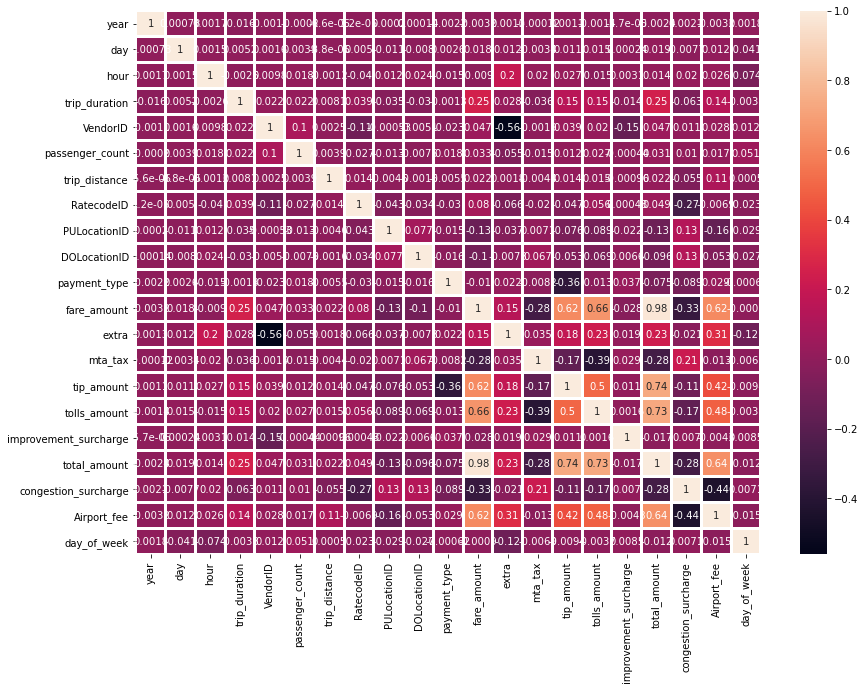

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
corr1=trips.corr(method='pearson')
fig, ax = plt.subplots(figsize=(14,10)) 
print(sns.heatmap(corr1, annot=True,linewidths=2,ax=ax))

* Affichage du nombre de course par quartier

In [28]:
# Chargement du fichier Taxi Zone Lookup Table (CSV)
df_locations = pd.read_csv('taxi+_zone_lookup.csv')

# Chargement du fichier Taxi Zone Shapefile (SHP)
gdf_zones = gpd.read_file('taxi_zones.shp')

In [29]:
gdf_zones

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [31]:
merged_df = pd.merge(trips, df_locations, left_on='PULocationID', right_on='LocationID', how='left')

In [32]:
counts_by_zone = merged_df['Zone'].value_counts()

In [33]:
gdf_zones = gdf_zones.merge(counts_by_zone, left_on='zone', right_index=True, how='left')

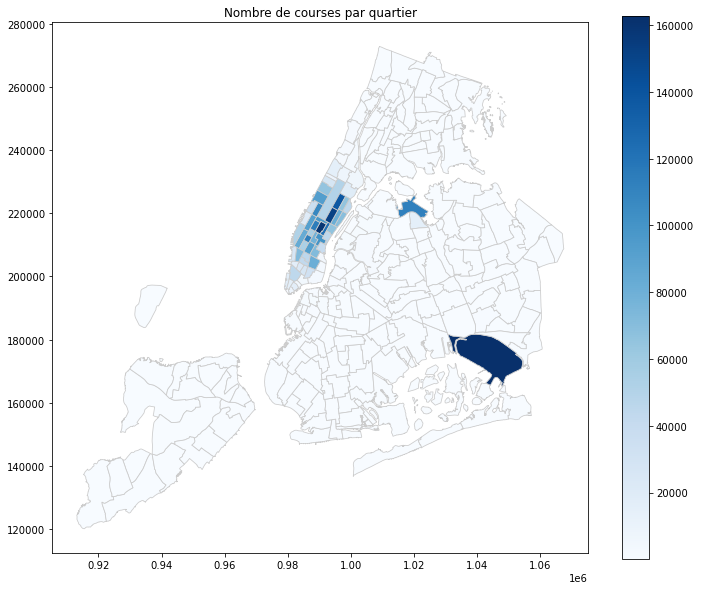

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
gdf_zones.plot(column='Zone', cmap='Blues', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Nombre de courses par quartier')
plt.show()

## Partie 2 : Utilisation des modèles de prédictions

### 1. Le modèle XGBoost

In [35]:
trips.drop(['Airport_fee','congestion_surcharge','improvement_surcharge','tolls_amount','tip_amount','mta_tax','extra','fare_amount'], axis = 1, inplace = True)

trips.head()

,year,day,hour,trip_duration,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,day_of_week
1,2023,1,0,0.518056,2,2023-03-01 00:08:25,2023-03-01 00:39:30,2.0,12.40,1.0,N,138,231,1,76.49,2
2,2023,1,0,0.239444,1,2023-03-01 00:15:04,2023-03-01 00:29:26,0.0,3.30,1.0,N,140,186,1,28.05,2
3,2023,1,0,0.191111,1,2023-03-01 00:49:37,2023-03-01 01:01:05,1.0,2.90,1.0,N,140,43,1,24.70,2
4,2023,1,0,0.050556,2,2023-03-01 00:08:04,2023-03-01 00:11:06,1.0,1.23,1.0,N,79,137,1,14.64,2
5,2023,1,0,0.140278,1,2023-03-01 00:09:09,2023-03-01 00:17:34,1.0,1.20,1.0,N,162,137,1,18.00,2


In [36]:
trips.drop('tpep_pickup_datetime', axis=1, inplace=True)
trips.drop('tpep_dropoff_datetime', axis=1, inplace=True)

In [37]:
trips.head()

,year,day,hour,trip_duration,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,total_amount,day_of_week
1,2023,1,0,0.518056,2,2.0,12.40,1.0,N,138,231,1,76.49,2
2,2023,1,0,0.239444,1,0.0,3.30,1.0,N,140,186,1,28.05,2
3,2023,1,0,0.191111,1,1.0,2.90,1.0,N,140,43,1,24.70,2
4,2023,1,0,0.050556,2,1.0,1.23,1.0,N,79,137,1,14.64,2
5,2023,1,0,0.140278,1,1.0,1.20,1.0,N,162,137,1,18.00,2


In [38]:
print( trips.isna().sum())

year                      0
day                       0
hour                      0
trip_duration             0
VendorID                  0
passenger_count       80513
trip_distance             0
RatecodeID            80513
store_and_fwd_flag    80513
PULocationID              0
DOLocationID              0
payment_type              0
total_amount              0
day_of_week               0
dtype: int64


In [39]:
trips.dropna(subset=["passenger_count"] , inplace=True)
trips.drop('store_and_fwd_flag', axis=1, inplace=True)

In [40]:
print( trips.isna().sum())

year               0
day                0
hour               0
trip_duration      0
VendorID           0
passenger_count    0
trip_distance      0
RatecodeID         0
PULocationID       0
DOLocationID       0
payment_type       0
total_amount       0
day_of_week        0
dtype: int64


In [41]:
import xgboost as xgb
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [42]:
X = trips.drop('total_amount', axis=1) 
y = trips['total_amount']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [44]:
xgb_model = xgb.XGBRegressor()

In [45]:
print(trips.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3240510 entries, 1 to 3316146
Data columns (total 13 columns):
 #   Column           Dtype  
---  ------           -----  
 0   year             int64  
 1   day              int64  
 2   hour             int64  
 3   trip_duration    float64
 4   VendorID         int32  
 5   passenger_count  float64
 6   trip_distance    float64
 7   RatecodeID       float64
 8   PULocationID     int32  
 9   DOLocationID     int32  
 10  payment_type     int64  
 11  total_amount     float64
 12  day_of_week      int64  
dtypes: float64(5), int32(3), int64(5)
memory usage: 309.0 MB
None


In [46]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [47]:
# Faire des prédictions sur l'ensemble de test
y_pred = xgb_model.predict(X_test)

In [48]:
from sklearn.metrics import r2_score

# Calculer le coefficient de détermination R²
r2 = r2_score(y_test, y_pred)

# Afficher le coefficient de détermination R²
print("Coefficient de détermination R² : {:.4f}".format(r2))

Coefficient de détermination R² : 0.9719


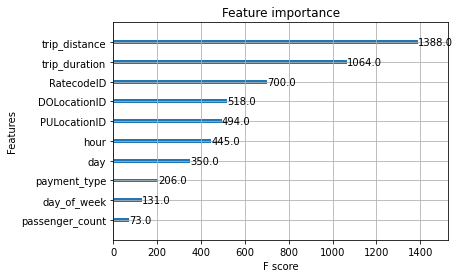

In [49]:
#Tracer l'importance des variables
xgb.plot_importance(xgb_model, max_num_features=10)  # Vous pouvez ajuster le nombre de variables affichées

#Afficher le graphique
plt.show()

### 2. Le modèle Gradient Boosting

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [51]:
# initialisation du modèle
model_gb = GradientBoostingRegressor()
# Adapter les données (entraînement du modèle)
model_gb.fit(X_train, y_train)
# Prédiction
y_predicted = model_gb.predict(X_test)

In [52]:
# Évaluation du modèle
rmse = mean_squared_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)

In [53]:
# Affichage des valeurs
print("Racine carrée de l'erreur quadratique moyenne : ", rmse)
print('Score R2 : ', r2)

Racine carrée de l'erreur quadratique moyenne :  18.3667730848829
Score R2 :  0.9621214814404128


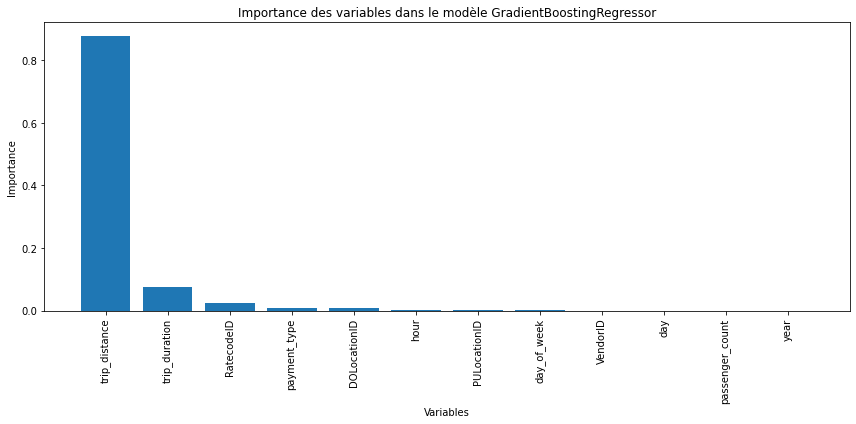

In [54]:
# Obtenez l'importance des variables
importances = model_gb.feature_importances_

# Triez les indices des variables par importance décroissante
sorted_indices = np.argsort(importances)[::-1]

feature_names = X_train.columns.tolist()
# Obtenez les noms des variables correspondant aux indices triés
sorted_feature_names = np.array(feature_names)[sorted_indices]

# Obtenez les importances triées
sorted_importances = importances[sorted_indices]

# Créez un graphique à barres pour visualiser les importances des variables
plt.figure(figsize=(12, 6))
plt.bar(range(len(importances)), sorted_importances)
plt.xticks(range(len(importances)), sorted_feature_names, rotation='vertical')
plt.xlabel('Variables')
plt.ylabel('Importance')
plt.title('Importance des variables dans le modèle GradientBoostingRegressor')
plt.tight_layout()
plt.show()

### 3. Les réseaux de neurones 

In [55]:
# Vérifier si Keras est installé (bibliothèque de  réseaux de neurones)
try:
    import keras
    print('Keras est déjà installé.')
except ImportError:
    print("Keras n'est pas installé. Installation en cours...")
    !pip install keras
# Vérifier si TensorFlow est installé (bibliothèque de calcul numérique en Apprentissage profond)
try:
    import tensorflow as tf
    print('TensorFlow est déjà installé.')
except ImportError:
    print("TensorFlow n'est pas installé. Installation en cours...")
    !pip install tensorflow

# Vérifier si les versions de Keras et de TensorFlow sont compatibles
if keras.__version__ != tf.keras.__version__:
    print('Warning: Les versions de  Keras et TensorFlow ne sont pas compatible.')
else:
    print('Keras et TensorFlow sont bien installés et compatibles.')

Keras est déjà installé.
TensorFlow est déjà installé.
Keras et TensorFlow sont bien installés et compatibles.


In [56]:
from tensorflow import keras
# Création du modèle
model_network = keras.Sequential()
model_network.add(keras.layers.Dense(units = 64, activation = 'relu', input_dim=X_train.shape[1]))
model_network.add(keras.layers.Dense(units = 32, activation = 'relu'))
model_network.add(keras.layers.Dense(units = 16, activation = 'relu'))
model_network.add(keras.layers.Dense(units = 8, activation = 'relu'))
model_network.add(keras.layers.Dense(units = 1, activation = 'linear'))
model_network.compile(loss='mse', optimizer="adam")

# Display the model
model_network.summary()

# Compilation du modèle (fonction model.compile)
model_network.compile(loss='mse', optimizer='adam', metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                832       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 3,585
Trainable params: 3,585
Non-trainable params: 0
_________________________________________________________________


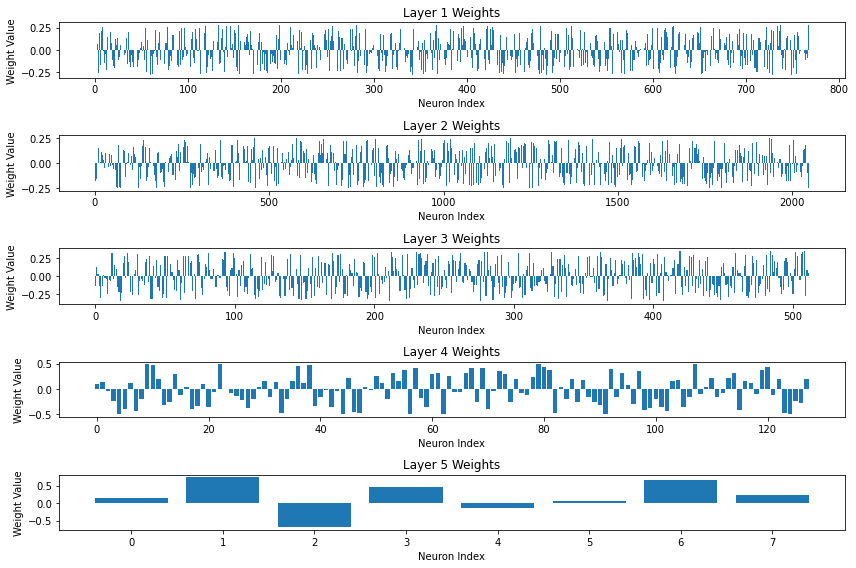

In [57]:
# Obtenir les poids de chaque couche
weights = []
for layer in model_network.layers:
    layer_weights = layer.get_weights()
    if layer_weights:
        weights.append(np.ravel(layer_weights[0]))

# Créer le graphique
fig, axs = plt.subplots(len(weights), 1, figsize=(12, 8))
for i, layer_weights in enumerate(weights):
    axs[i].bar(range(len(layer_weights)), layer_weights)
    axs[i].set_title(f"Layer {i+1} Weights")
    axs[i].set_xlabel("Neuron Index")
    axs[i].set_ylabel("Weight Value")
plt.tight_layout()
plt.show()


In [58]:
# Entraînement du modèle (fonction fit() )
history = model_network.fit(X_train, y_train, epochs=20, verbose=1, batch_size=64)

Epoch 1/20
40507/40507 [==============================] - 48s 1ms/step - loss: 60.8961 - accuracy: 4.0503e-05
Epoch 2/20
40507/40507 [==============================] - 46s 1ms/step - loss: 37.2445 - accuracy: 4.0503e-05
Epoch 3/20
40507/40507 [==============================] - 46s 1ms/step - loss: 29.3093 - accuracy: 4.0503e-05
Epoch 4/20
40507/40507 [==============================] - 46s 1ms/step - loss: 27.4878 - accuracy: 4.0503e-05
Epoch 5/20
40507/40507 [==============================] - 46s 1ms/step - loss: 25.5251 - accuracy: 4.0503e-05
Epoch 6/20
40507/40507 [==============================] - 46s 1ms/step - loss: 24.8911 - accuracy: 4.0503e-05
Epoch 7/20
40507/40507 [==============================] - 46s 1ms/step - loss: 24.4295 - accuracy: 4.0503e-05
Epoch 8/20
40507/40507 [==============================] - 46s 1ms/step - loss: 24.4896 - accuracy: 4.0503e-05
Epoch 9/20
40507/40507 [==============================] - 49s 1ms/step - loss: 23.5611 - accuracy: 4.0503e-05
Epoch 10/2

In [59]:
# Evaluation du modèle 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred = model_network.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(rmse, mae , r2)

20254/20254 [==============================] - 18s 873us/step
4.577715183929627 2.2340496595246844 0.956782696966836


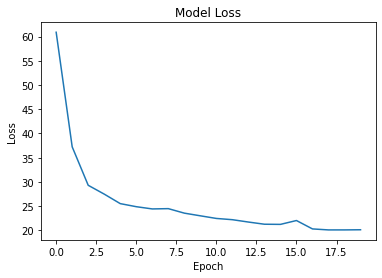

In [60]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()